# A Notebook for pressure-gravity mode instability plots

## Imports

In [1]:
from matplotlib import rc, rcParams
import matplotlib.pyplot as plt
import numpy
from pycbc import conversions
from pycbc import cosmology
from pycbc.distributions import uniform, uniform_log
from IPython.display import Image

## Generating Fig 1. p-g mode prior plots

/home/steven.reyes/pycbc-nl-tides-fixed/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


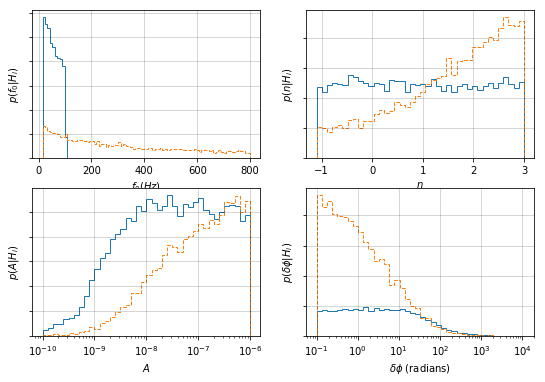

In [2]:
numpy.random.seed(seed=1234)
# Number of samples to generate for prior plot
num_samples_init = 1000000

### Draw masses from uniform prior
mass1_uni_pdf = uniform.Uniform(samples=(1.0,2.0))
mass2_uni_pdf = uniform.Uniform(samples=(1.0,2.0))

# Source frame masses
mass1_uni_samples = mass1_uni_pdf.rvs(num_samples_init)["samples"]
mass2_uni_samples = mass2_uni_pdf.rvs(num_samples_init)["samples"]

# Only keep samples where mass1 > mass2
keep_idx = mass1_uni_samples > mass2_uni_samples
mass1_uni_samples = mass1_uni_samples[keep_idx]
mass2_uni_samples = mass2_uni_samples[keep_idx]

# Convert to chirp mass and apply chirp mass cuts
chirp_mass_uni = conversions.mchirp_from_mass1_mass2(mass1_uni_samples,
                                                     mass2_uni_samples)

# Chirp mass cuts
keep_idx = chirp_mass_uni > 1.1876
chirp_mass_uni = chirp_mass_uni[keep_idx]
mass1_uni_samples = mass1_uni_samples[keep_idx]
mass2_uni_samples = mass2_uni_samples[keep_idx]

keep_idx = chirp_mass_uni < 1.2076
chirp_mass_uni = chirp_mass_uni[keep_idx]
mass1_uni_samples = mass1_uni_samples[keep_idx]
mass2_uni_samples = mass2_uni_samples[keep_idx]

num_samples_final = len(chirp_mass_uni)

### Make f0 p-g mode parameter space set
f0_small_pdf = uniform.Uniform(samples=(15., 100.))
f0_small_samples = f0_small_pdf.rvs(num_samples_final)["samples"]

f0_big_pdf = uniform.Uniform(samples=(15., 800.))
f0_big_samples = f0_big_pdf.rvs(num_samples_final)["samples"]

### Make the rest of the p-g-mode priors
n_pdf = uniform.Uniform(samples=(-1.1, 2.999))
n_samples = n_pdf.rvs(num_samples_final)["samples"]

A_pdf = uniform_log.UniformLog10(samples=(10**-10,10**-6))
A_samples = A_pdf.rvs(num_samples_final)["samples"]

# Calculate dphi arrays
flow = 20.0

dphi_uniform_small = conversions.nltides_gw_phase_diff_isco(flow,
                                                    f0_small_samples,
                                                    A_samples,
                                                    n_samples,
                                                    mass1_uni_samples,
                                                    mass2_uni_samples)

dphi_uniform_large = conversions.nltides_gw_phase_diff_isco(flow,
                                                    f0_big_samples,
                                                    A_samples,
                                                    n_samples,
                                                    mass1_uni_samples,
                                                    mass2_uni_samples)
keep_idx1 = dphi_uniform_small > 0.1
keep_idx2 = dphi_uniform_large > 0.1

num_bins = 85
fig, axarr = plt.subplots(2, 2)
bin_edges = numpy.linspace(15.0, 800.0, num_bins + 1, endpoint=True)
axarr[0][0].hist(f0_small_samples[keep_idx1], bins=bin_edges,
                 histtype="step", normed=True,
                 label="Prior for $f_0$ $\in$ (15, 100) $\mathrm{Hz}$")
axarr[0][0].hist(f0_big_samples[keep_idx2], bins=bin_edges,
                 histtype="step", normed=True,
                 label="Prior for $f_0$ $\in$ (15, 800) $\mathrm{Hz}$",
                 linestyle="--")
axarr[0][0].set_xlabel("$f_0 (Hz)$")
axarr[0][0].set_ylabel("$p(f_0 | H_i)$")

num_bins = 40
bin_edges = numpy.linspace(-1.1, 3.0, num_bins + 1, endpoint=True)
axarr[0][1].hist(n_samples[keep_idx1], bins=bin_edges,
                 histtype="step", normed=True,)
axarr[0][1].hist(n_samples[keep_idx2], bins=bin_edges,
                 histtype="step", normed=True,
                 linestyle="--")
axarr[0][1].set_xlabel("$n$")
axarr[0][1].set_ylabel("$p(n | H_i)$")

bin_edges = numpy.logspace(-10.0, -6.0, num_bins + 1, endpoint=True)
axarr[1][0].hist(A_samples[keep_idx1], bins=bin_edges,
                 histtype="step", normed=True,
                 weights=A_samples[keep_idx1]*numpy.log(10))
axarr[1][0].hist(A_samples[keep_idx2], bins=bin_edges,
                 histtype="step", normed=True,
                 weights=A_samples[keep_idx2]*numpy.log(10),
                 linestyle="--")
axarr[1][0].set_xlabel("$A$")
axarr[1][0].set_ylabel("$p(A | H_i)$")
axarr[1][0].set_xscale("log")

bin_edges = numpy.logspace(-1.0, 4.05, num_bins + 1, endpoint=True)
axarr[1][1].hist(dphi_uniform_small[keep_idx1], bins=bin_edges,
                 histtype="step", normed=True,
                 weights=dphi_uniform_small[keep_idx1]*numpy.log(10))

axarr[1][1].hist(dphi_uniform_large[keep_idx2], bins=bin_edges,
                 histtype="step", normed=True,
                 weights=dphi_uniform_large[keep_idx2]*numpy.log(10),
                 linestyle="--")
axarr[1][1].set_xlabel("$\delta \phi$ $\mathrm{(radians)}$")
axarr[1][1].set_ylabel("$p(\delta \phi | H_i)$")
axarr[1][1].set_xscale("log")

axarr[0][0].grid(color="k", which="major", axis="both", alpha=0.2)
axarr[0][0].yaxis.set_ticklabels([])
axarr[0][1].grid(color="k", which="major", axis="both", alpha=0.2)
axarr[0][1].yaxis.set_ticklabels([])
axarr[1][0].grid(color="k", which="major", axis="both", alpha=0.2)
axarr[1][0].yaxis.set_ticklabels([])
axarr[1][1].grid(color="k", which="major", axis="both", alpha=0.2)
axarr[1][1].yaxis.set_ticklabels([])

length_column = 6
fig.set_size_inches(1.5*length_column, length_column)

plt.show()

## Bayes Factor Calculations
We provide a small verification calculation for thinned posterior results to verify
the Bayes Factor calculations in the text. For the sake of not mounting multiple files we
simply provide the evidence from De et al's DNS Gaussian mass distribution run and Uniform mass distribution run
with the common equation of state constraints on each neutron star.

In [3]:
from pycbc.io.inference_hdf import InferenceFile
from pycbc.inference import option_utils
import emcee
import numpy

# Thinned chains from
# "Constraints on non-linear tides due to p-g mode coupling from the neutron star merger GW170817"
# by Steven Reyes and Duncan A. Brown

fp1 = InferenceFile('gaussian_small_f0_range.hdf','r')
fp2 = InferenceFile('gaussian_large_f0_range.hdf','r')
fp3 = InferenceFile('uniform_small_f0_range.hdf','r')
fp4 = InferenceFile('uniform_large_f0_range.hdf','r')

def calc_evidence(fp, start_iter=None, end_iter=None, interval_iter=None):

    stats_group=fp.stats_group
    parameters = fp[stats_group].keys()
    logstats = fp.read_samples(parameters, samples_group=stats_group, thin_start=start_iter,
                               thin_end=end_iter, thin_interval=interval_iter, temps='all', flatten=False)
    logls = logstats['loglr'] + fp.lognl
    betas = numpy.array(fp.attrs['betas'])
    ntemps = fp.ntemps
    nwalkers = fp.nwalkers
    ndim = len(fp.variable_args)
    dummy_sampler = emcee.PTSampler(ntemps, nwalkers, ndim, None, None, betas=betas)
    lnz, dlnz = dummy_sampler.thermodynamic_integration_log_evidence(logls=logls, fburnin=0.0)
    return lnz, dlnz


# Because the posterior hdf files were thinned beforehand we start our integration at iteration 0
# and run in intervals of 1, to the end of the file.
lnz1, dlnz1  = calc_evidence(fp1, start_iter=0, end_iter=-1, interval_iter=1)
lnz2, dlnz2 = calc_evidence(fp2, start_iter=0, end_iter=-1, interval_iter=1)
lnz3, dlnz3 = calc_evidence(fp3, start_iter=0, end_iter=-1, interval_iter=1)
lnz4, dlnz4 = calc_evidence(fp4, start_iter=0, end_iter=-1, interval_iter=1)

# Calculated from full runs and sampled at same thin_interval
De_et_al_gaussian_evidence_ln_z = -1348453.30987
De_et_al_uniform_evidence_ln_z = -1348453.08037


print("Gaussian mass distribution, small f0 range")
bayes_factor=numpy.exp(lnz1 - De_et_al_gaussian_evidence_ln_z)
print("log10 Bayes factor=%f\n"%numpy.log10(bayes_factor))

print("Gaussian mass distribution, large f0 range")
bayes_factor = numpy.exp(lnz2 - De_et_al_gaussian_evidence_ln_z)
print("log10 Bayes factor=%f\n"%numpy.log10(bayes_factor))

print("Uniform mass distribution, small f0 range")
bayes_factor=numpy.exp(lnz3 - De_et_al_uniform_evidence_ln_z)
print("log10 Bayes factor=%f\n"%numpy.log10(bayes_factor))

print("Uniform mass distribution, large f0 range")
bayes_factor = numpy.exp(lnz4 - De_et_al_uniform_evidence_ln_z)
print("log10 Bayes factor=%f\n"%numpy.log10(bayes_factor))
fp1.close()
fp2.close()
fp3.close()
fp4.close()

Gaussian mass distribution, small f0 range
log10 Bayes factor=-6.371896

Gaussian mass distribution, large f0 range
log10 Bayes factor=-4.757193

Uniform mass distribution, small f0 range
log10 Bayes factor=-9.211644

Uniform mass distribution, large f0 range
log10 Bayes factor=-6.075410



## Posterior Plots (Figures 2 and 3 and more)

We provide plotting scripts to plot the posteriors from the thinned posterior files.
They provide posteriors near the iterations presented in the paper, although other iterations of the
files can be chosen to be plotted.

#### Posterior for Gaussian Mass Distribution for $f_0$ between 15 and 100 Hz

In [ ]:

!pycbc_inference_plot_posterior --plot-scatter \
--plot-contour \
--z-arg loglr \
--verbose \
--iteration -1 \
--input-file 'gaussian_small_f0_range.hdf' \
--output-file "gaussian_f0_15_100_Hz_posterior.png" \
--plot-marginal \
--parameters 'mchirp/(1+redshift(40.7)):$\mathcal{M}^{src}_{c}$' 'return_base10_log(amplitude):$log_{10}$ A' n 'f0:$f_0$' 'return_base10_log(nltides_gw_phase_diff_isco(20.0, f0, amplitude, n, mass1/(1+redshift(40.7)), mass2/(1+redshift(40.7)))):$log_{10}$ $\delta \phi$' \
--scale 'mchirp/(1+redshift(40.7)):linear' 'return_base10_log(amplitude):linear' 'f0:linear' 'n:linear' 'return_base10_log(nltides_gw_phase_diff_isco(20.0, f0, amplitude, n, mass1/(1+redshift(40.7)), mass2/(1+redshift(40.7)))):linear'


2018-08-21 18:46:21,613 Loading parameters
2018-08-21 18:46:21,613 Reading input file gaussian_small_f0_range.hdf
2018-08-21 18:46:21,619 Loading samples
2018-08-21 18:46:21,664 Getting likelihood stats
2018-08-21 18:46:21,697 Plotting
/home/steven.reyes/pycbc-nl-tides-fixed/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [ ]:
Image('gaussian_f0_15_100_Hz_posterior.png')

#### Posterior for Uniform Mass Distribution for $f_0$ between 15 and 100 Hz

In [ ]:

!pycbc_inference_plot_posterior --plot-scatter \
--plot-contour \
--z-arg loglr \
--verbose \
--iteration -1 \
--input-file 'uniform_small_f0_range.hdf' \
--output-file "uniform_f0_15_100_Hz_posterior.png" \
--plot-marginal \
--parameters 'mchirp/(1+redshift(40.7)):$\mathcal{M}^{src}_{c}$' 'return_base10_log(amplitude):$log_{10}$ A' n 'f0:$f_0$' 'return_base10_log(nltides_gw_phase_diff_isco(20.0, f0, amplitude, n, mass1/(1+redshift(40.7)), mass2/(1+redshift(40.7)))):$log_{10}$ $\delta \phi$' \
--scale 'mchirp/(1+redshift(40.7)):linear' 'return_base10_log(amplitude):linear' 'f0:linear' 'n:linear' 'return_base10_log(nltides_gw_phase_diff_isco(20.0, f0, amplitude, n, mass1/(1+redshift(40.7)), mass2/(1+redshift(40.7)))):linear'


In [ ]:
Image('uniform_f0_15_100_Hz_posterior.png')

#### Posterior for Gaussian Mass Distribution for $f_0$ between 15 and 800 Hz

In [ ]:

!pycbc_inference_plot_posterior --plot-scatter \
--plot-contour \
--z-arg loglr \
--verbose \
--iteration -1 \
--input-file 'gaussian_large_f0_range.hdf' \
--output-file "gaussian_f0_15_800_Hz_posterior.png" \
--plot-marginal \
--parameters 'mchirp/(1+redshift(40.7)):$\mathcal{M}^{src}_{c}$' 'return_base10_log(amplitude):$log_{10}$ A' n 'f0:$f_0$' 'return_base10_log(nltides_gw_phase_diff_isco(20.0, f0, amplitude, n, mass1/(1+redshift(40.7)), mass2/(1+redshift(40.7)))):$log_{10}$ $\delta \phi$' \
--scale 'mchirp/(1+redshift(40.7)):linear' 'return_base10_log(amplitude):linear' 'f0:linear' 'n:linear' 'return_base10_log(nltides_gw_phase_diff_isco(20.0, f0, amplitude, n, mass1/(1+redshift(40.7)), mass2/(1+redshift(40.7)))):linear'


In [ ]:
Image('gaussian_f0_15_800_Hz_posterior.png')

#### Posterior for Uniform Mass Distribution for $f_0$ between 15 and 800 Hz

In [ ]:

!pycbc_inference_plot_posterior --plot-scatter \
--plot-contour \
--z-arg loglr \
--verbose \
--iteration -1 \
--input-file 'uniform_large_f0_range.hdf' \
--output-file "uniform_f0_15_800_Hz_posterior.png" \
--plot-marginal \
--parameters 'mchirp/(1+redshift(40.7)):$\mathcal{M}^{src}_{c}$' 'return_base10_log(amplitude):$log_{10}$ A' n 'f0:$f_0$' 'return_base10_log(nltides_gw_phase_diff_isco(20.0, f0, amplitude, n, mass1/(1+redshift(40.7)), mass2/(1+redshift(40.7)))):$log_{10}$ $\delta \phi$' \
--scale 'mchirp/(1+redshift(40.7)):linear' 'return_base10_log(amplitude):linear' 'f0:linear' 'n:linear' 'return_base10_log(nltides_gw_phase_diff_isco(20.0, f0, amplitude, n, mass1/(1+redshift(40.7)), mass2/(1+redshift(40.7)))):linear'


In [ ]:
Image('uniform_f0_15_800_Hz_posterior.png')